# Imports  

In [1]:
from gliderad2cp import process_adcp

# Section 1: calculate velocity shear

## 1.1 Begin ADCP Data Processing

Set paths to input files and specify options

In [2]:
# import pooch

# server = "https://zenodo.org/records/10082274/files/"
# mission = "sea057_M43"
# data_source = pooch.create(
#     path=pooch.os_cache("gliderad2cp"),
#     base_url=server,
#     registry={
#         "sea057_M43.ad2cp.00000_1.nc": "sha256:775055eff485476af1cf79462e6ae400df04608bc1263434ea9a393e556d7b72",
#         "sea057_M43.ad2cp.00000_2.nc": "sha256:71738df881c6a3d770b9c87f2d0607be979b1a75f2fa254c13720195b0cfa97e",
#         "SEA057_M43.pqt": "2e72eda509d1c7027c9ed5ec70266b9bb161203e085c3de780aa9ee8ccb9cbce",
#     },
# )

In [3]:
# for filename in data_source.registry_files:
#     data_source.fetch(filename)

In [47]:
import datetime
import json
import logging
import warnings
from datetime import datetime as dt
from glob import glob
from pathlib import Path
from urllib import request

import gsw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d
from scipy.optimize import fmin

warnings.filterwarnings(action="ignore", message="Mean of empty slice")
warnings.filterwarnings(action="ignore", message="invalid value encountered in divide")
warnings.filterwarnings(
    action="ignore", message="invalid value encountered in true_divide"
)
warnings.filterwarnings(action="ignore", message="Degrees of freedom <= 0 for slice.")

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']  # Specify a font 

In [18]:
ad2cpdatadir = '/Users/gong/GitHub/jlglider/ad2cp/data/';

glider_path_csv = ad2cpdatadir + 'SEA064_M48.csv';
ad2cp_path_nc = ad2cpdatadir + 'sea064_M48.ad2cp.00000.nc';

#glider_pqt_path = data_source.path / 'SEA057_M43.pqt'
#adcp_path = f"{data_source.path}/sea057_M43*.nc"

options = {
    'debug_plots' : True,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    'ADCP_regrid_correlation_threshold': 25,
    'plots_directory': 'plots',
    }


## 1.2 Load ADCP data and add necessary glider variables

In [19]:
ADCP, data, options = process_adcp.load_adcp_glider_data(ad2cp_path_nc, glider_path_csv, options)

## 1.3 Start QC Calculate depth of each individual measurement


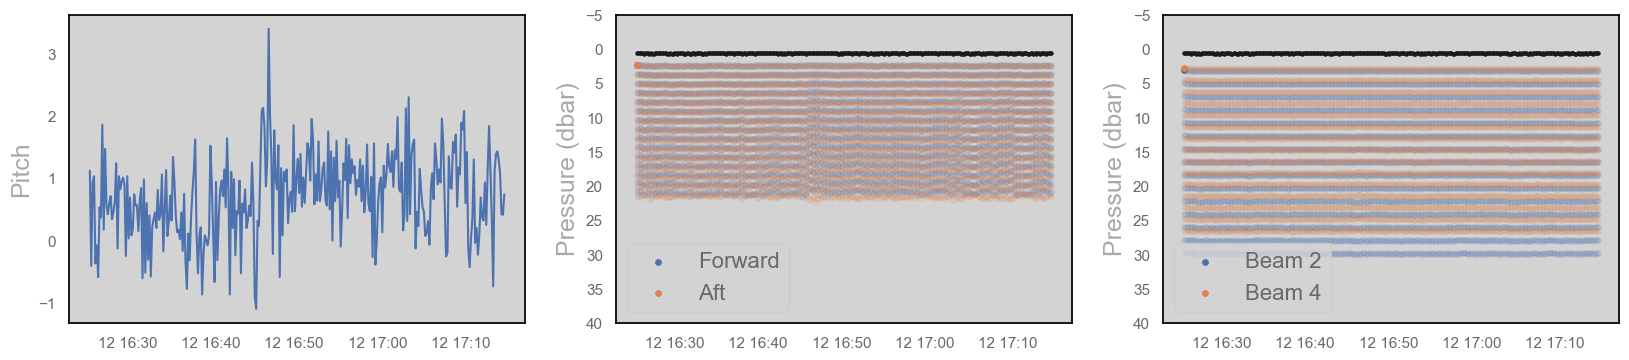

In [20]:
ADCP = process_adcp.remapADCPdepth(ADCP, options)

## 1.4 Correct ADCP Heading

Optimization terminated successfully.
         Current function value: 30.063041
         Iterations: 517
         Function evaluations: 780


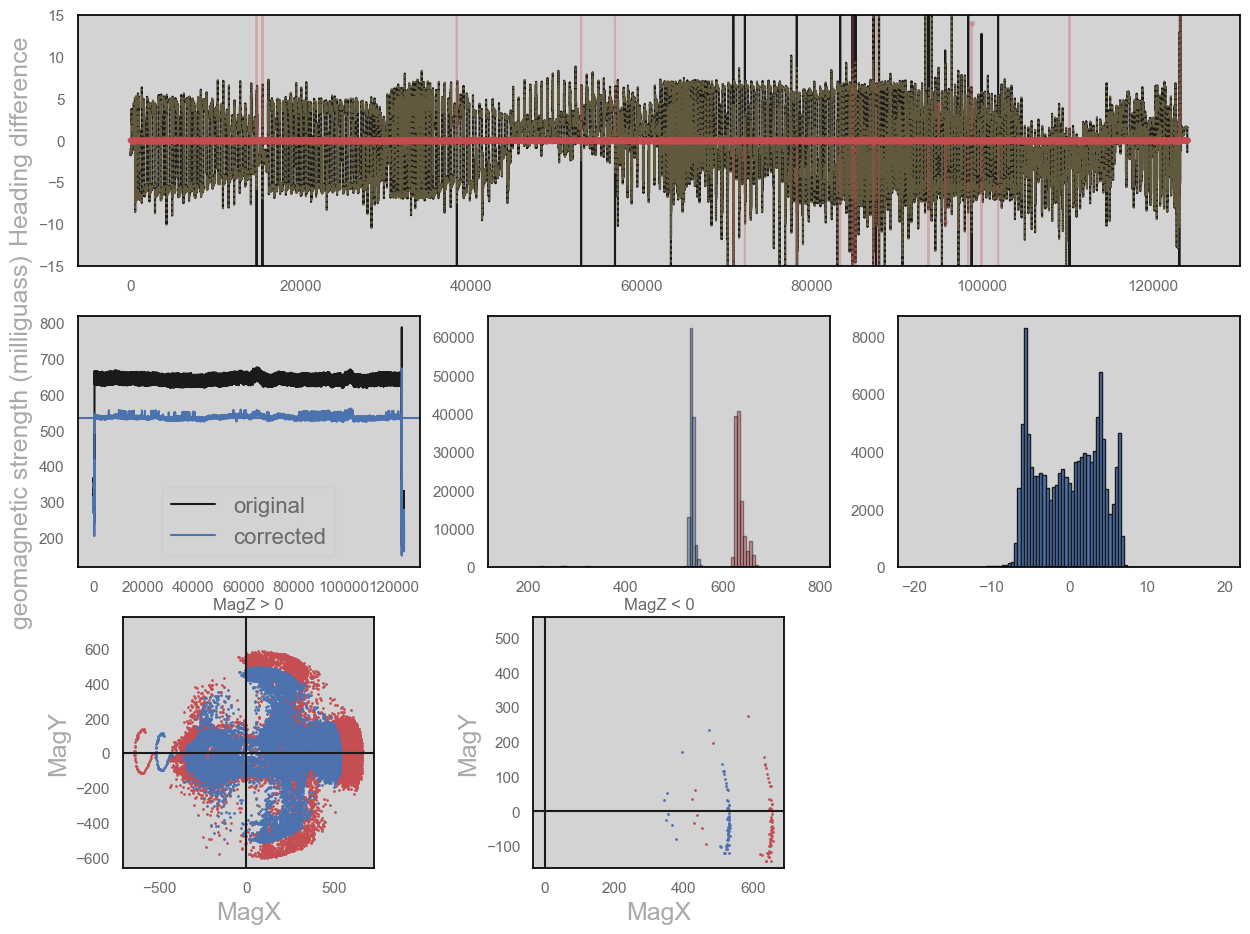

In [21]:
ADCP = process_adcp.correct_heading(ADCP, data, options)

## 1.5 Perform soundspeed correction

In [22]:
ADCP = process_adcp.soundspeed_correction(ADCP)

## 1.6 Outlier and poor correlation removal


Now we need to think. What do we discard, what do we keep, do we interpolate across missing bins?

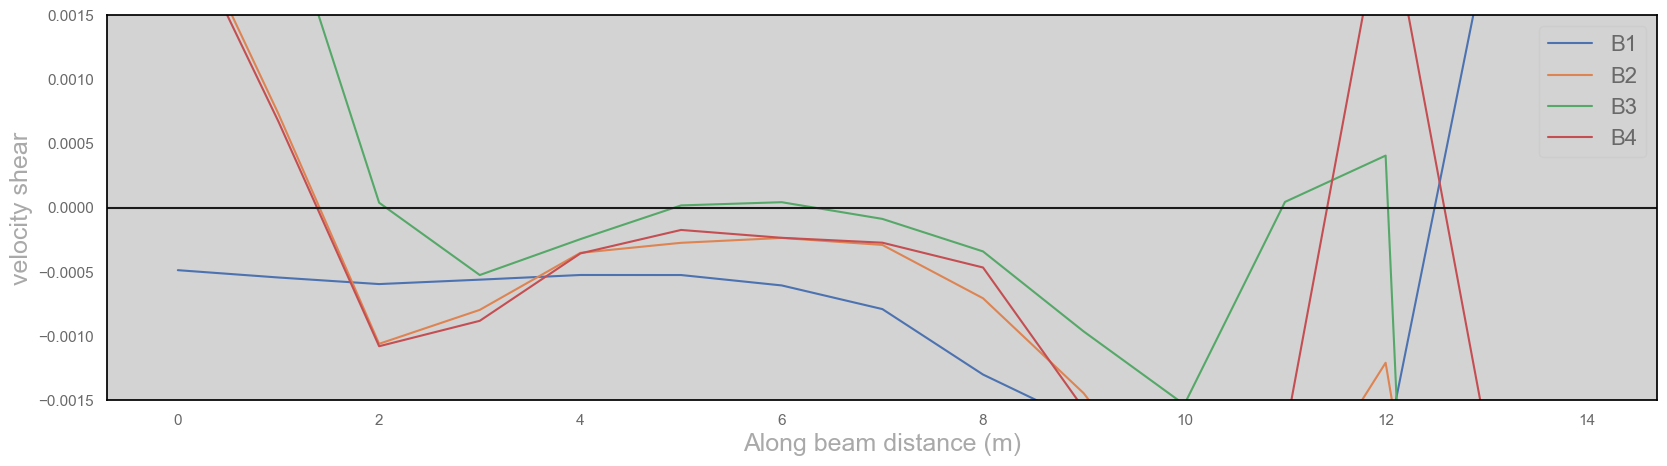

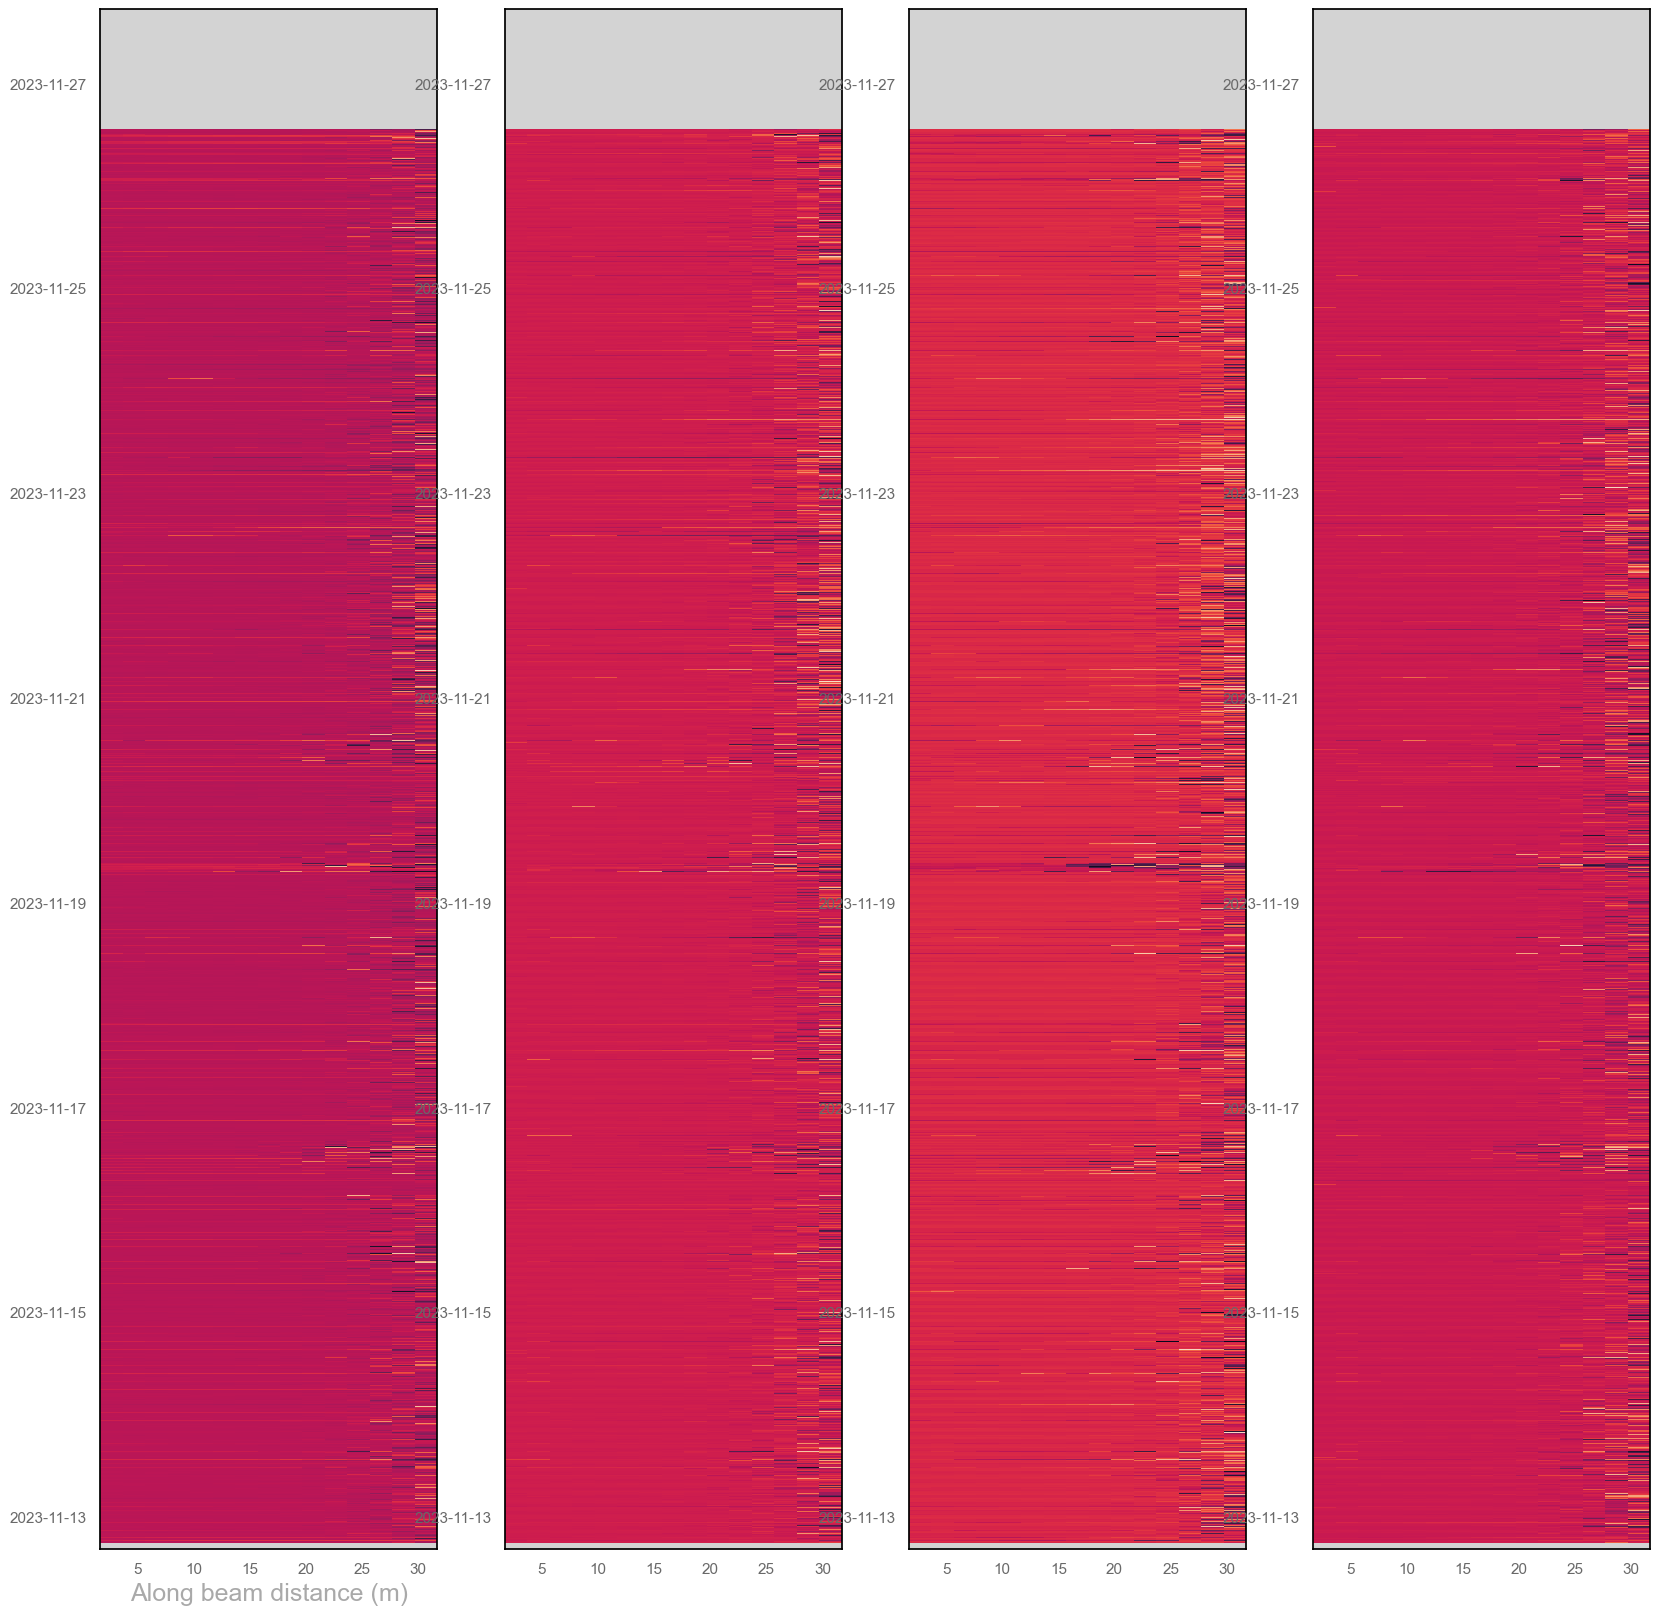

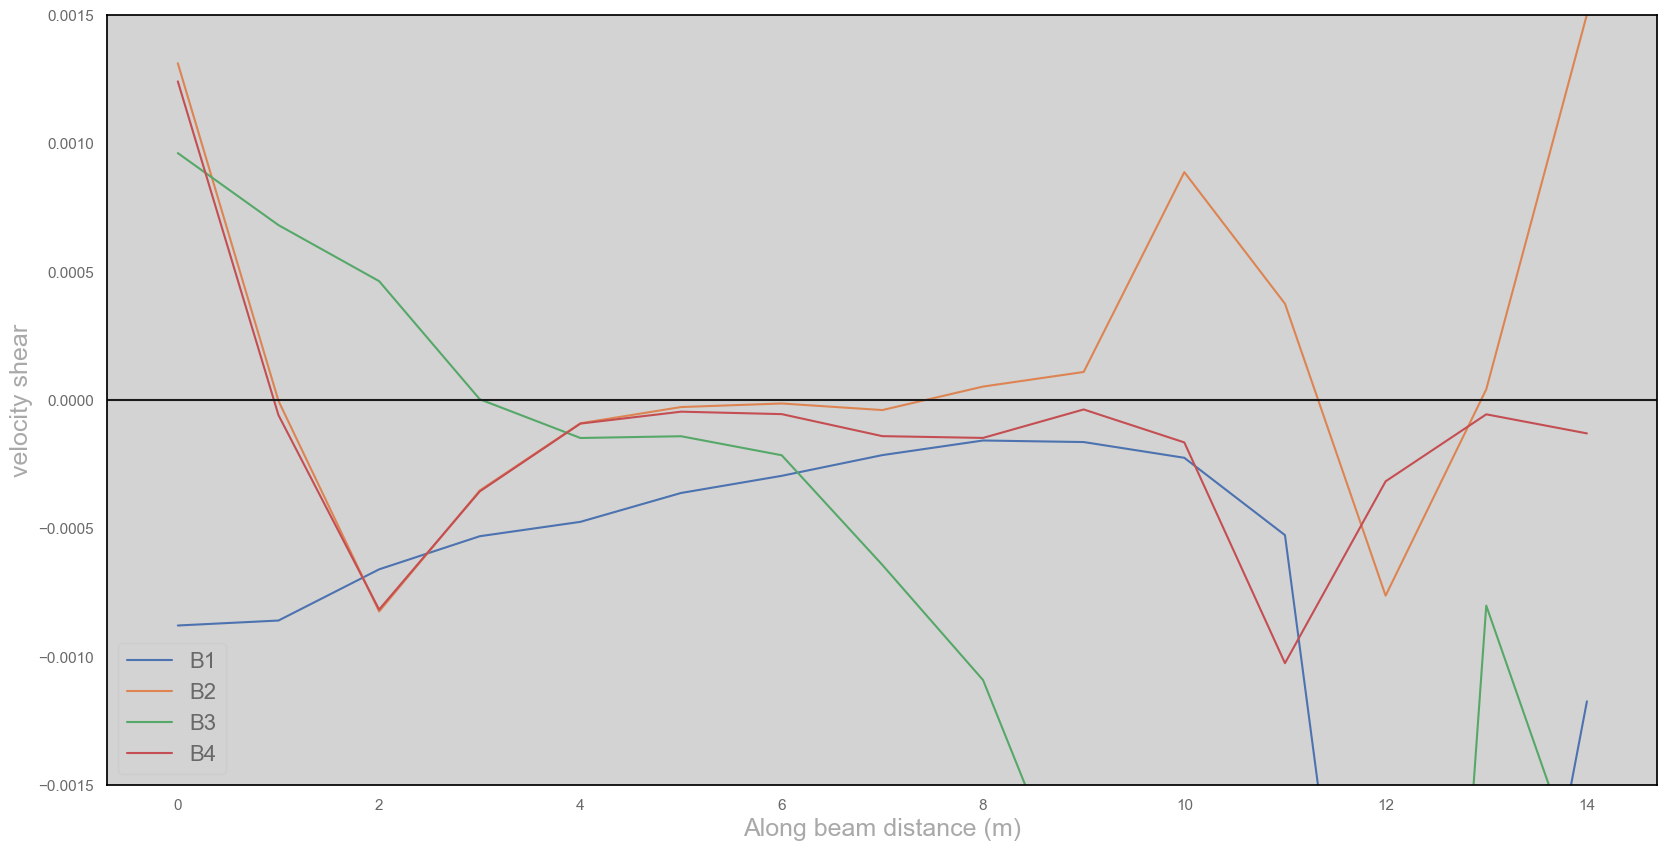

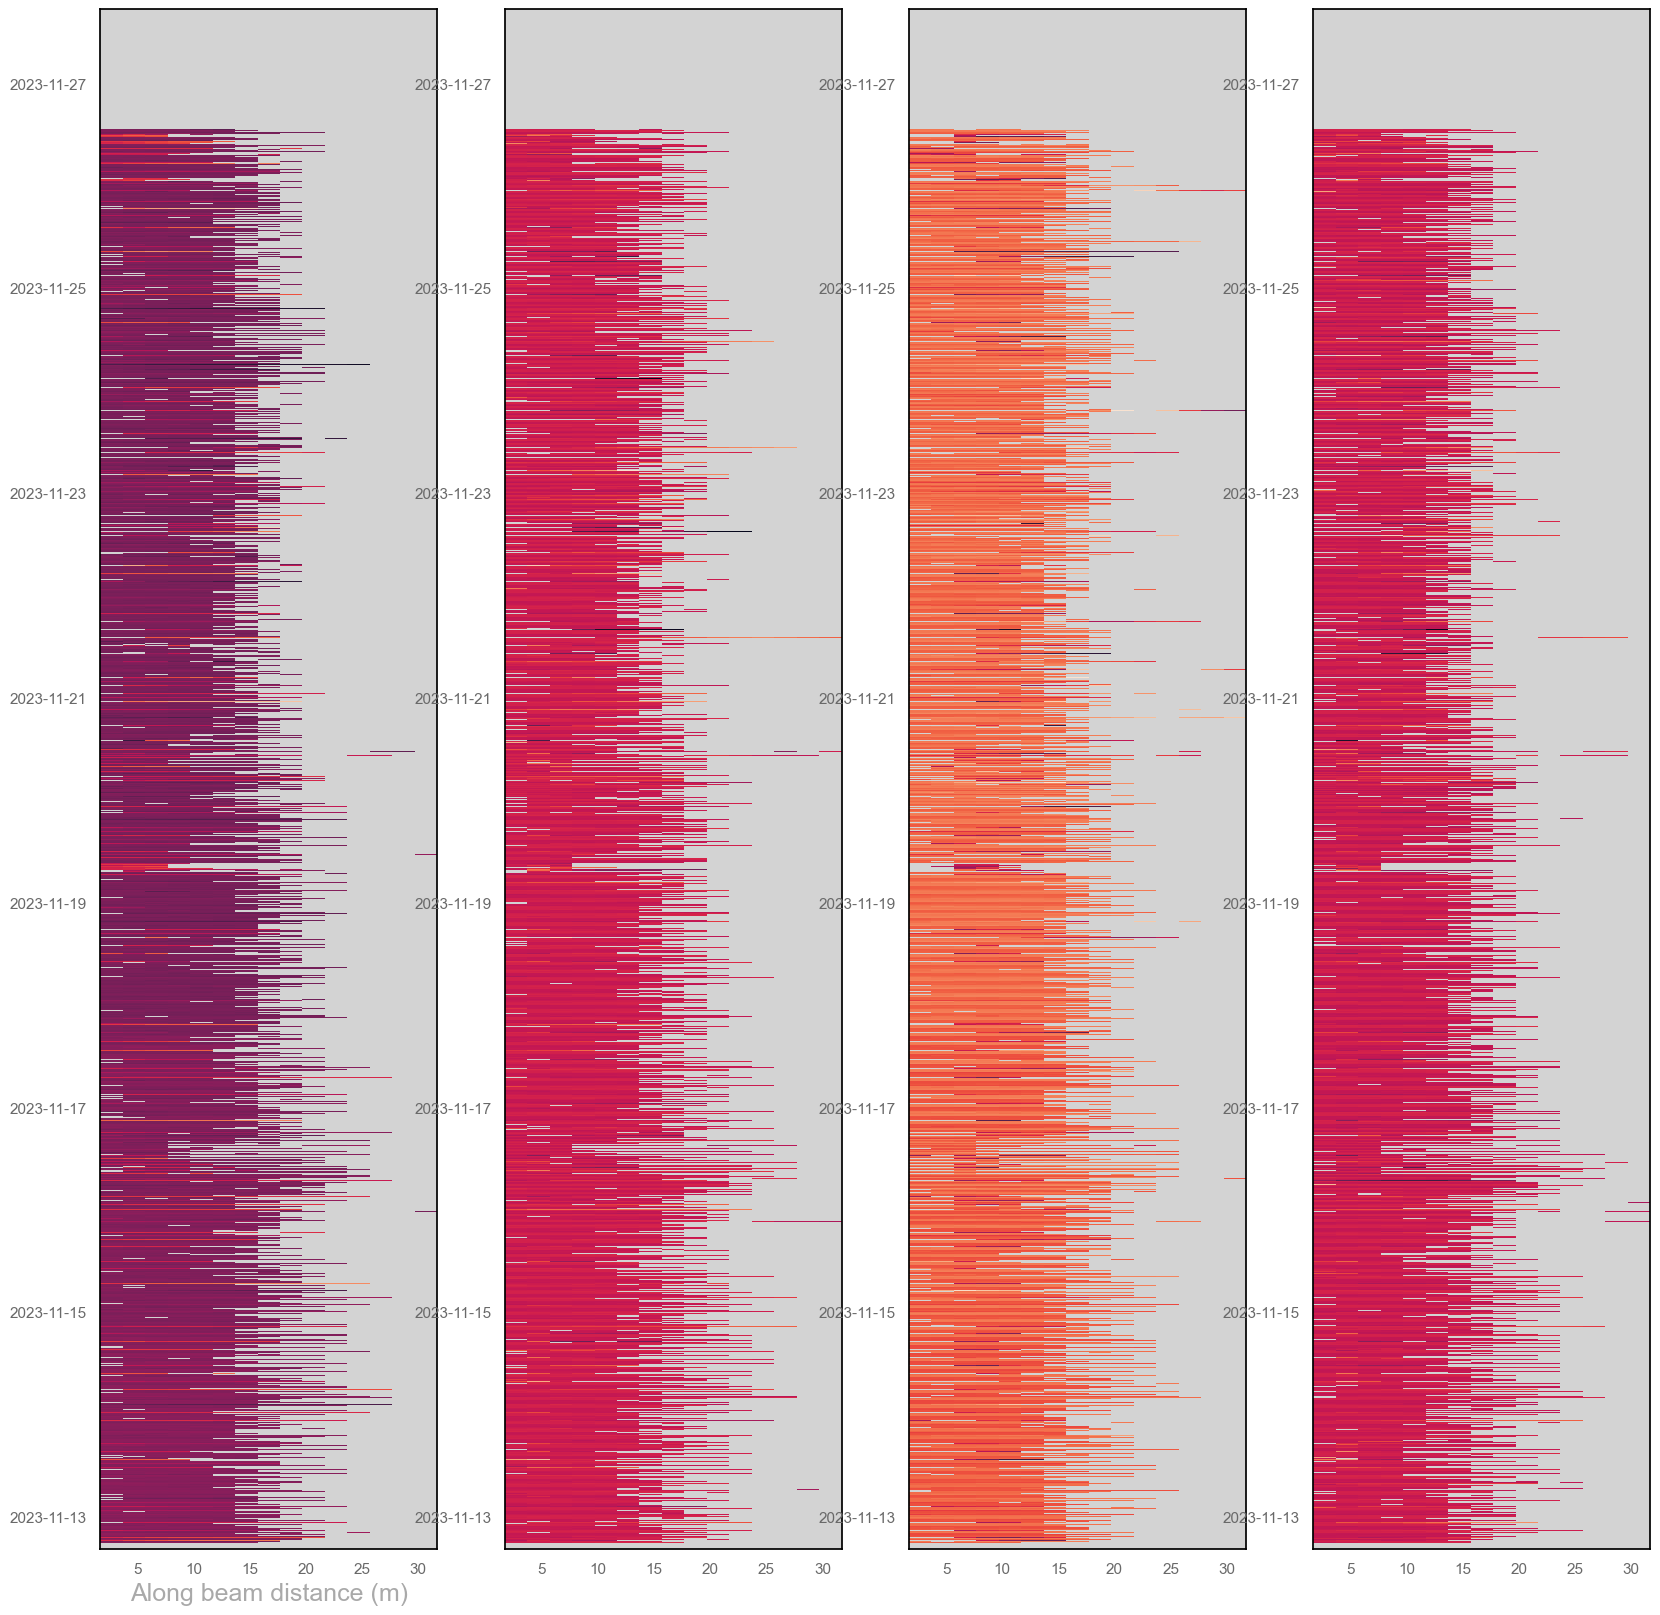

In [23]:
ADCP = process_adcp.remove_outliers(ADCP, options)

## 1.7 How many good data per bin?

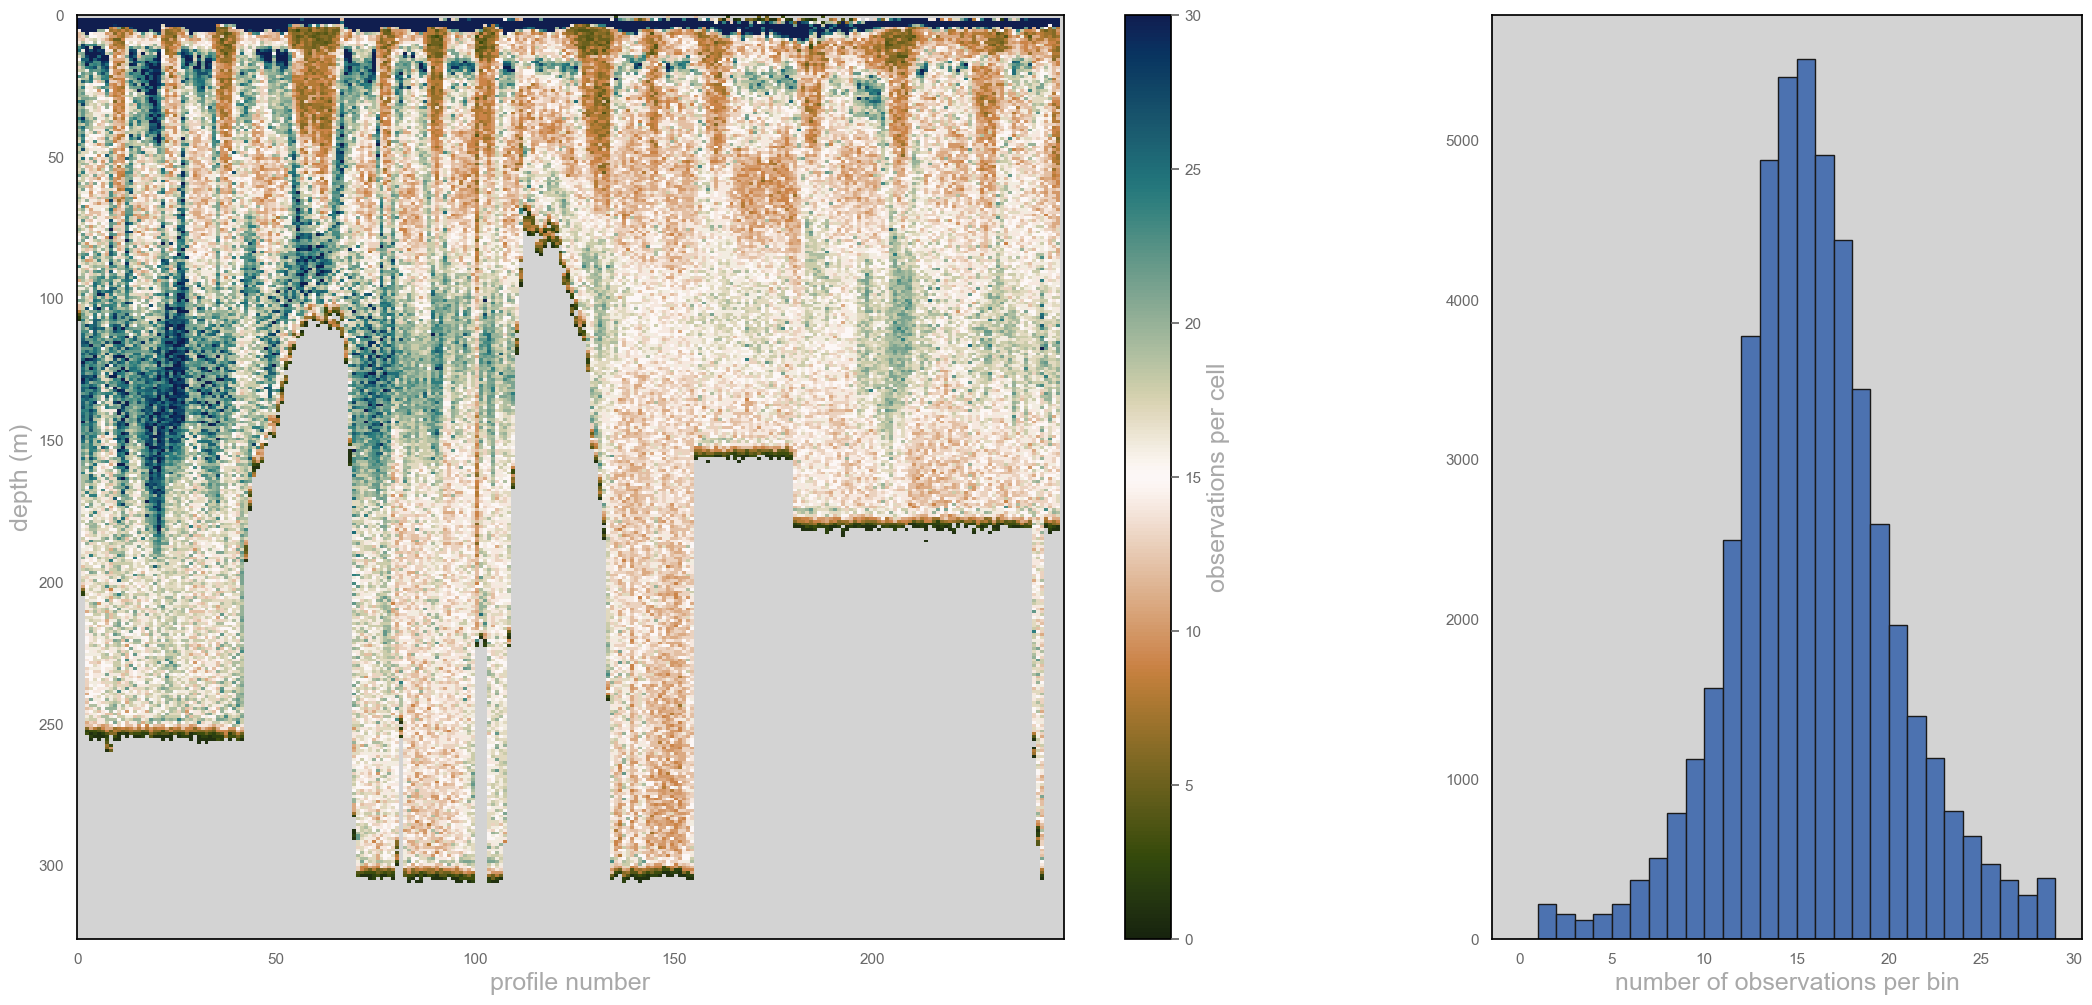

In [29]:
process_adcp.plot_data_density(ADCP, options)

### 1.8 Correct shear bias

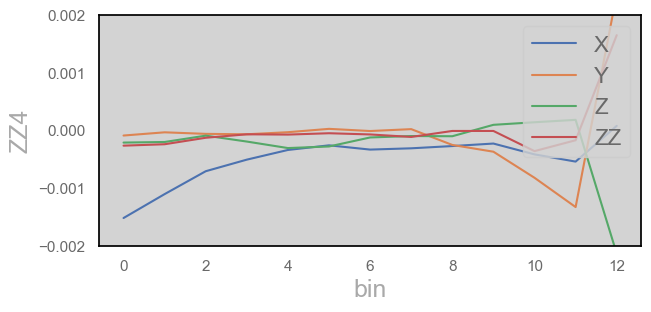

In [30]:
ADCP = process_adcp.correct_shear(ADCP, options)

## 1.9 Remap 3-beam configuration onto isobars

In [45]:
    depth_offsets=None
    bin_size = ADCP.attrs["avg_cellSize"]
    blanking_distance = ADCP.attrs["avg_blankingDistance"]

In [49]:
    y_res = 1  # TODO: move to options
    plot_num = 0
    def calc_ideal_depth_offsets(bin_size, blanking_distance):
        if options["top_mounted"]:
            direction = 1
        else:
            direction = -1
        threshold = options["ADCP_regrid_correlation_threshold"]
        means = [
            np.nanmean(ADCP["CorrelationBeam" + str(x)], axis=0) for x in [1, 2, 3, 4]
        ]
        stds = [
            np.nanstd(ADCP["CorrelationBeam" + str(x)], axis=0) for x in [1, 2, 3, 4]
        ]

        max_bin = np.argmin(
            abs(np.nanmean([means[x] for x in range(4)], axis=0) - threshold)
        )
        max_distance = blanking_distance + max_bin * bin_size + 0.5 * bin_size
        if options["debug_plots"]:
            plt.close("all")
            plt.figure(figsize=(15, 7))
            [
                plt.plot(ADCP["Correlation Range"].values, means[x], "-k")
                for x in range(4)
            ]
            [
                plt.plot(ADCP["Correlation Range"].values, means[x] + stds[x], ":r")
                for x in range(4)
            ]
            [
                plt.plot(ADCP["Correlation Range"].values, means[x] - stds[x], ":r")
                for x in range(4)
            ]
            plt.axvline(max_bin, color="g")
            plt.title("Bin correlations")
            plt.ylabel("Correlation (%)")
            plt.xlabel("Along beam distance (m)")
            plt.plot(ADCP["Correlation Range"].values, means[0], "-k", label="mean")
            plt.plot(
                ADCP["Correlation Range"].values,
                means[0] - stds[0],
                ":r",
                label="mean ± std.dev",
            )
            if options["plots_directory"]:
                save_plot(options["plots_directory"], "bin_correlations")

        return np.arange(0, max_distance + bin_size, bin_size / 2) * direction
    def save_plot(plot_dir, plot_name):
        """utility function to save plots to a user defined directory"""
        global plot_num
        plot_num += 1
        plt.savefig(f"{plot_dir}/{str(plot_num).zfill(2)}_{plot_name}.png")



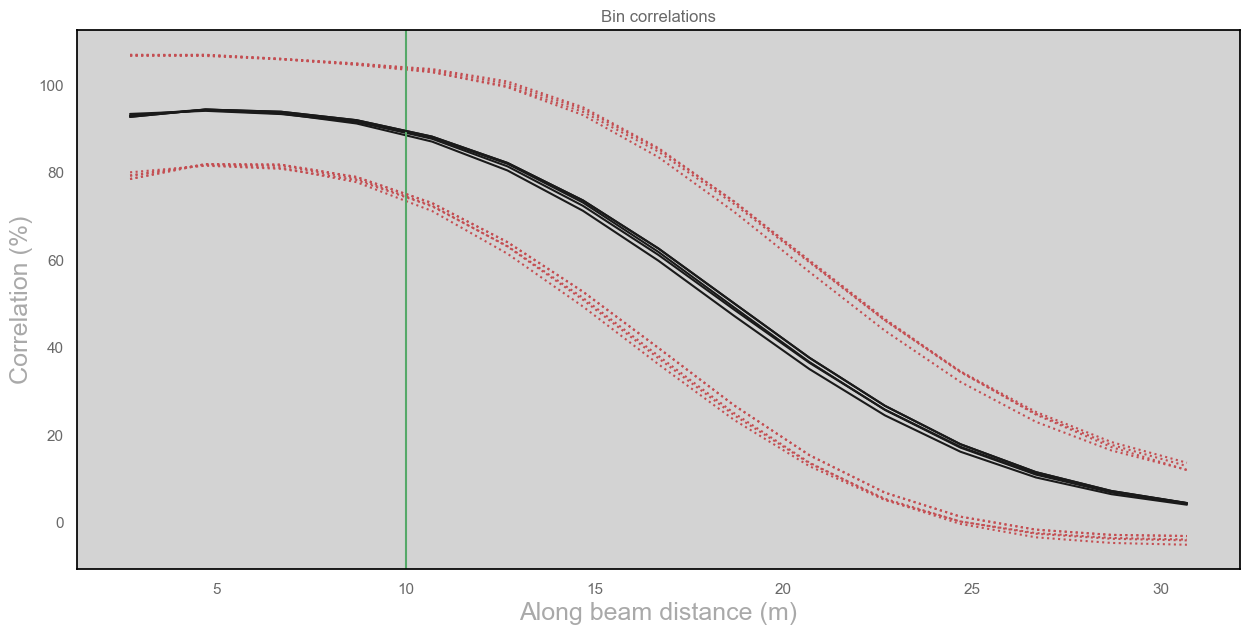

In [50]:
    if depth_offsets is None:
        depth_offsets = calc_ideal_depth_offsets(bin_size, blanking_distance)


OutOfBoundsDatetime: cannot convert input 739202.6843222026 with the unit 'D'

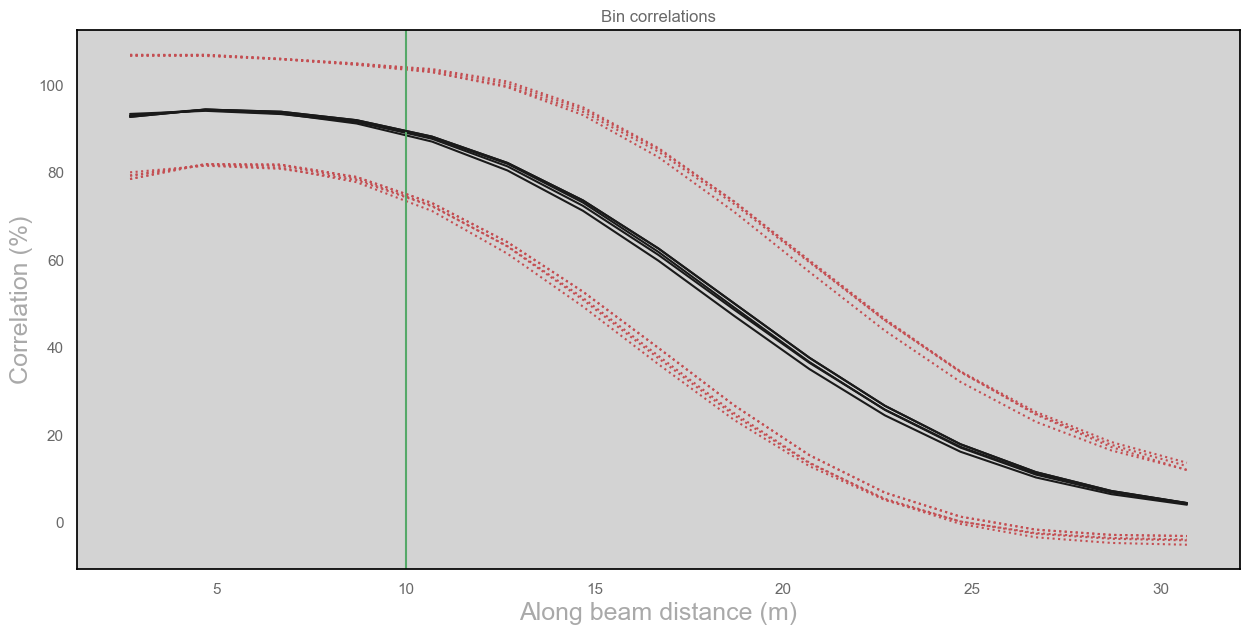

In [33]:
ADCP = process_adcp.regridADCPdata(ADCP, options)

## 1.10 Transform beams to XYZ and ENU velocities

In [31]:
ADCP = process_adcp.calcXYZfrom3beam(ADCP, options)

KeyError: 'V1'

In [28]:
ADCP = process_adcp.calcENUfromXYZ(ADCP, data, options)

KeyError: 'X'

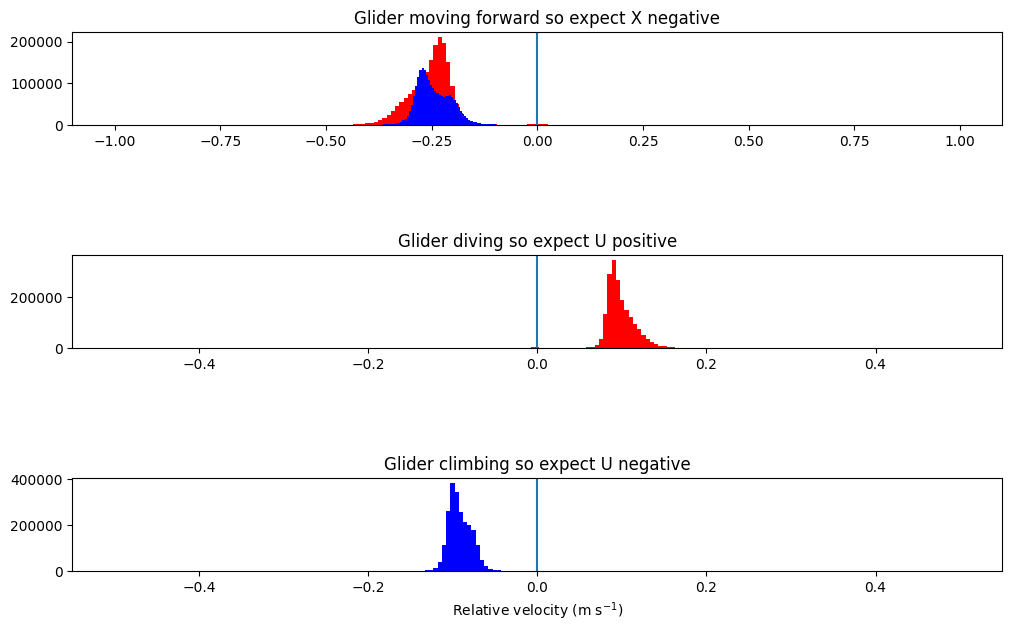

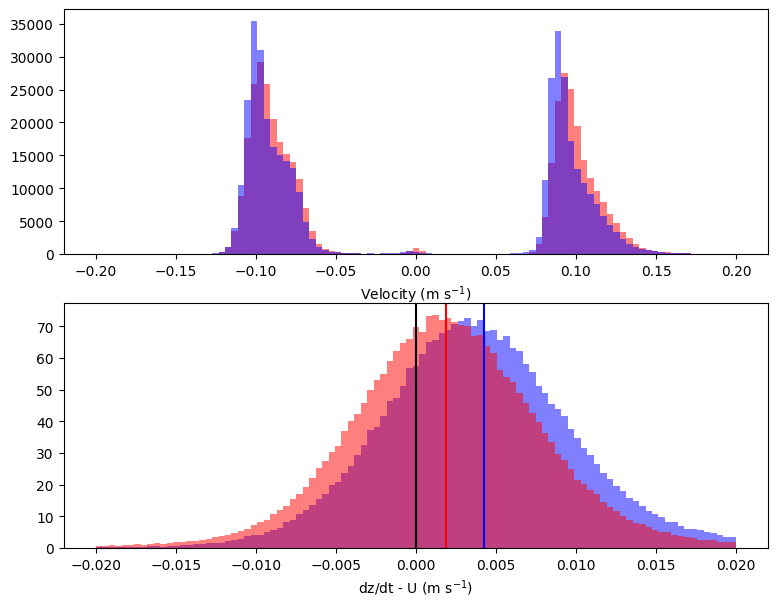

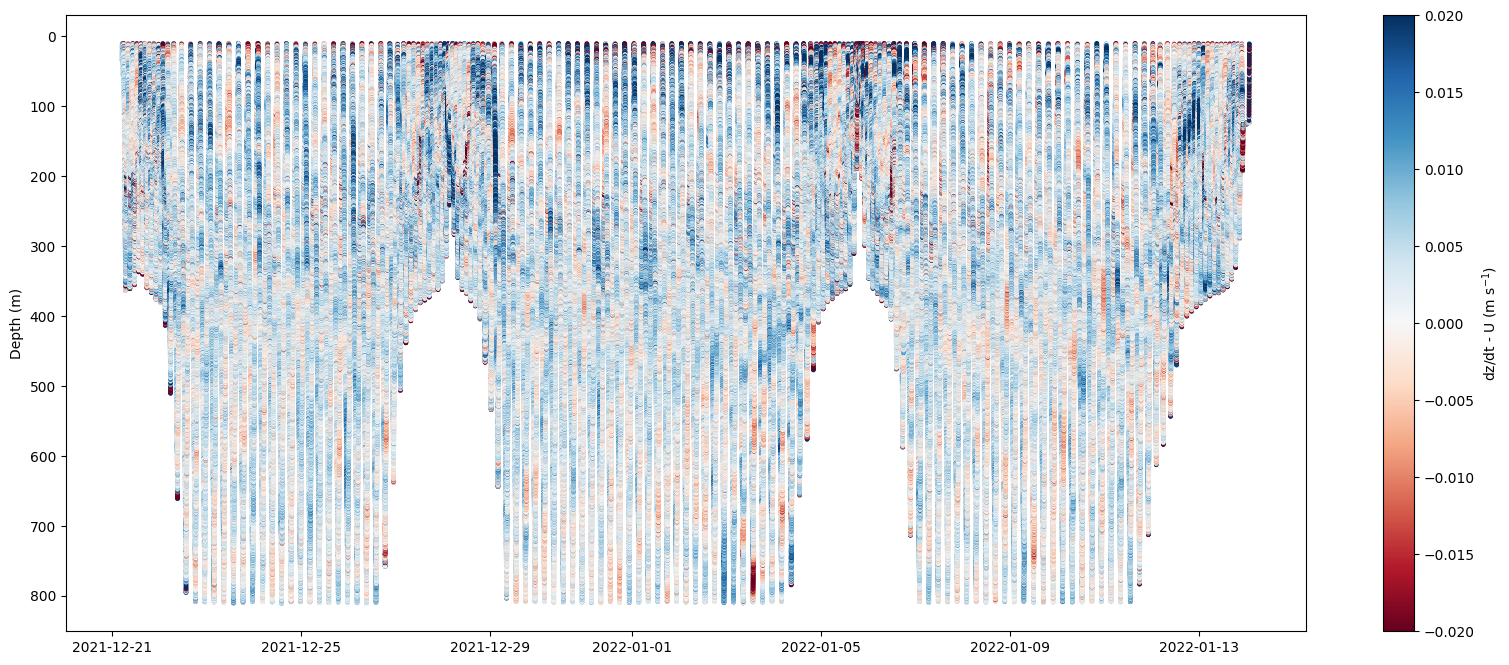

In [15]:
process_adcp.verify_calcENUfromXYZ(ADCP, options)

## 1.11 Grid shear

In [32]:
xaxis, yaxis, taxis, days = process_adcp.grid_shear_data(ADCP, data, options)
out = process_adcp.grid_data(ADCP, data, {}, xaxis, yaxis)
ds = process_adcp.make_dataset(out)

AttributeError: 'Dataset' object has no attribute 'Sh_E'

# 1.12 Write out data

**ds** is an xarray dataset of data gridded by depth bin and profile number, ready for processing

In [18]:
ds.to_netcdf("gridded_shear.nc")

# Part 2: shear to velocity

After calculating velocity shear, there are several options for integrating and referencing this shear to obtain velocity profiles. This section demonstrates some of these options

# 2.1 Add extra variables for integrating shear

To calculate dive average current we require more variables, including estimates of the glider's movement through the water.

In [19]:
import pandas as pd

extra_data = pd.read_parquet(glider_pqt_path)
extra_data.index = data.index
data["speed_vert"] = extra_data["speed_vert"]
data["speed_horz"] = extra_data["speed_horz"]
data["dead_reckoning"] = extra_data["dead_reckoning"]
data["nav_resource"] = extra_data["nav_state"]
data["dive_number"] = extra_data["dive_number"]

## 2.2. Calculate dive-averaged current

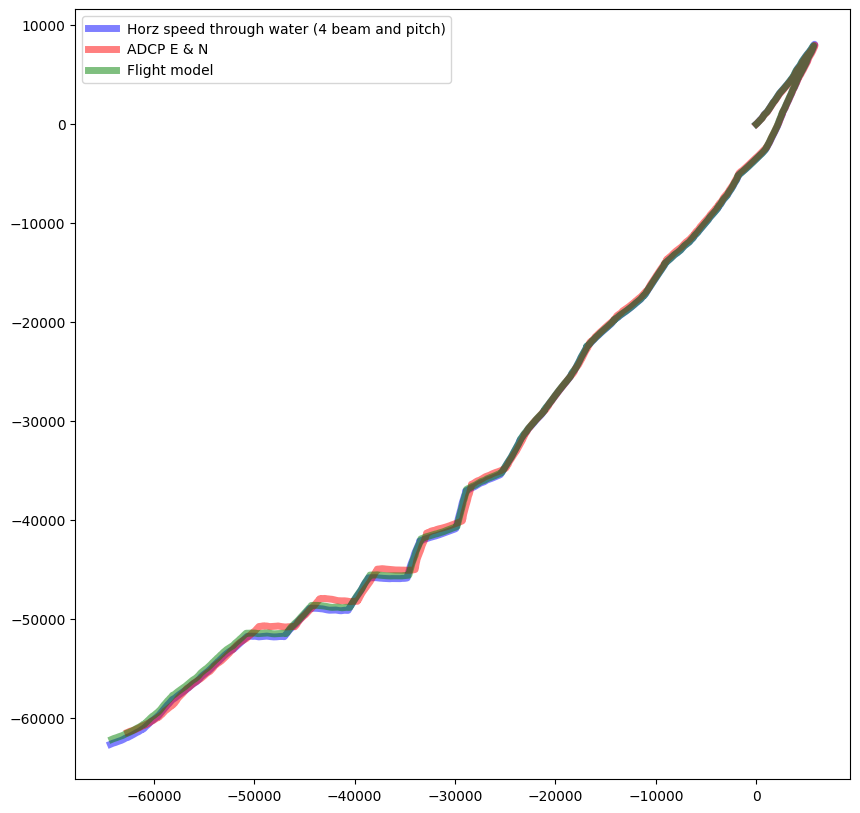

In [20]:
process_adcp.plot_subsurface_movement(ADCP, data, options)

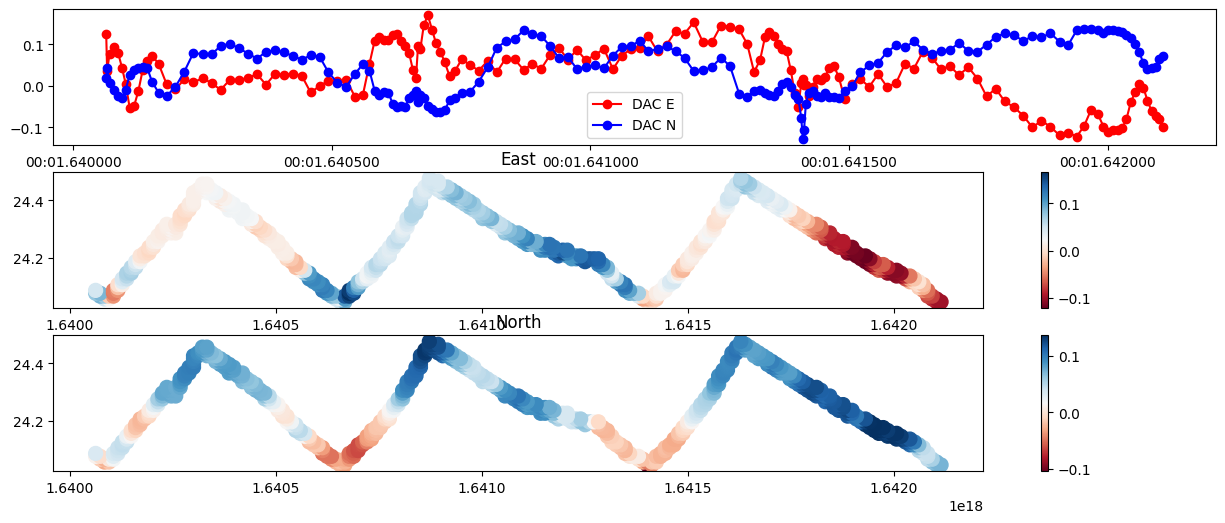

In [21]:
data = process_adcp.get_DAC(ADCP, data, options)

## 2.3. Get surface drift

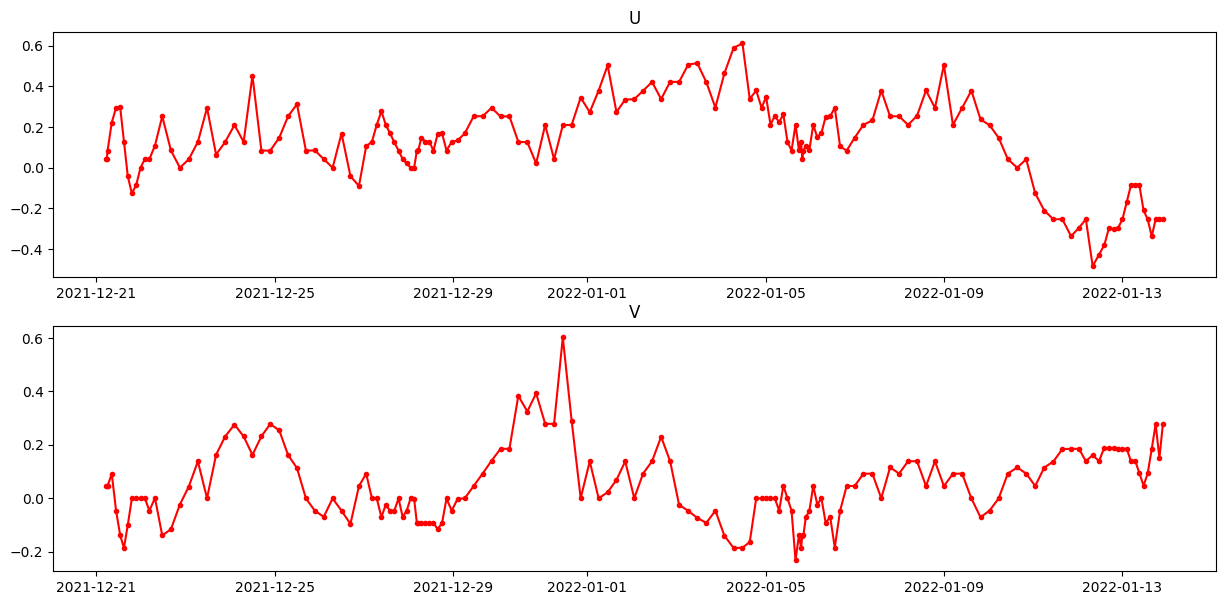

In [22]:
dE,dN,dT = process_adcp.getSurfaceDrift(data, options)

## 2.4. Get bottom track data 
Bottom track data only calculated if the ADCP is bottom mounted

In [23]:
ADCP = process_adcp.bottom_track(ADCP, adcp_path, options)

## 2.5. Reference ADCP data

Here we reference data to dive average current (DAC).

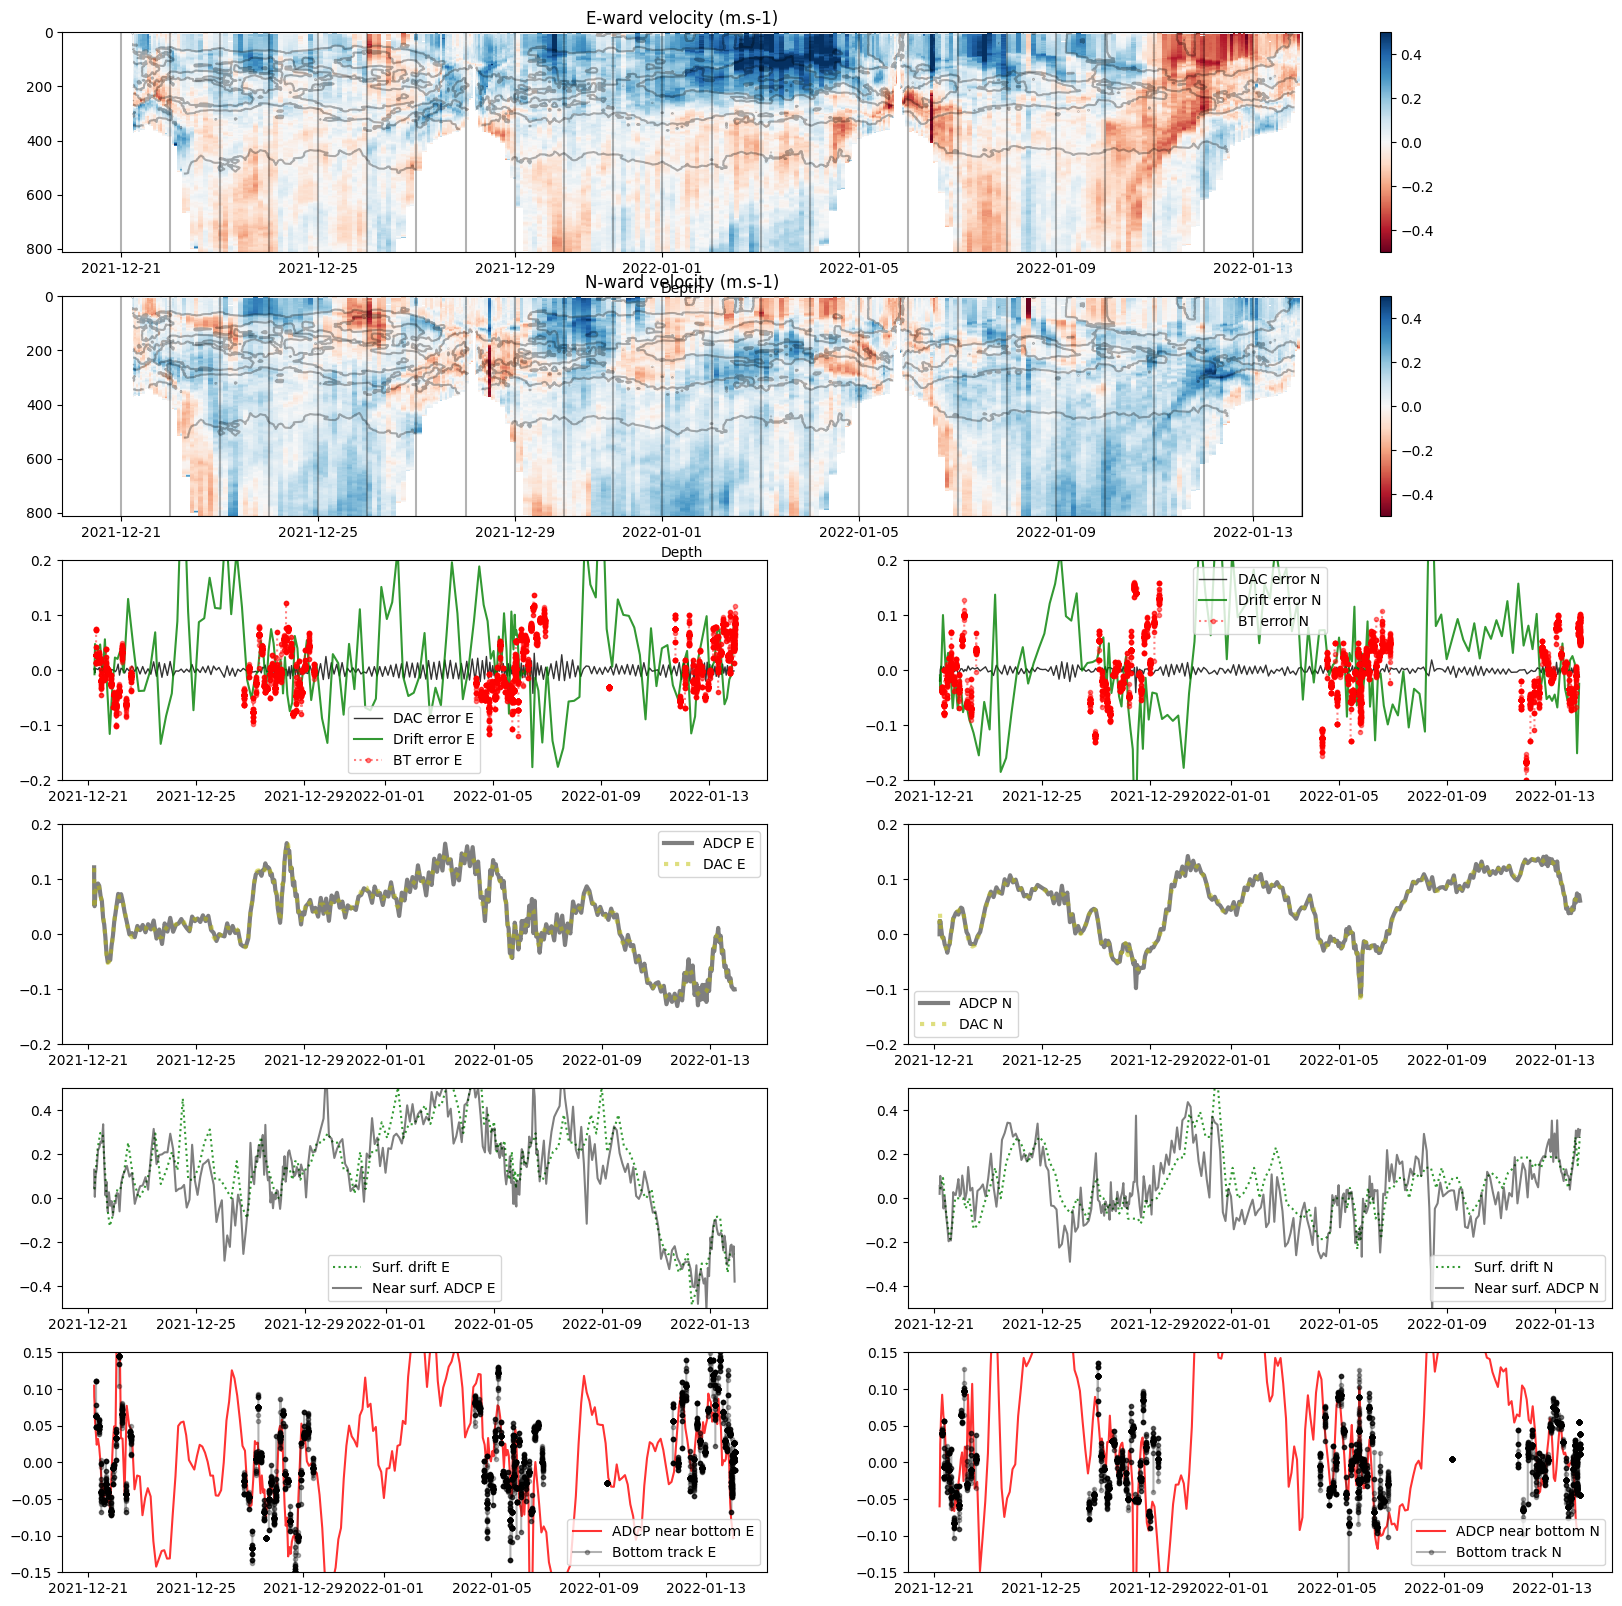

In [24]:
out = process_adcp.reference_shear(ADCP, data, dE,dN,dT, xaxis, yaxis, taxis, options)

## 2.6 Grid and plot data

In [25]:
out = process_adcp.grid_data(ADCP, data, out, xaxis, yaxis)

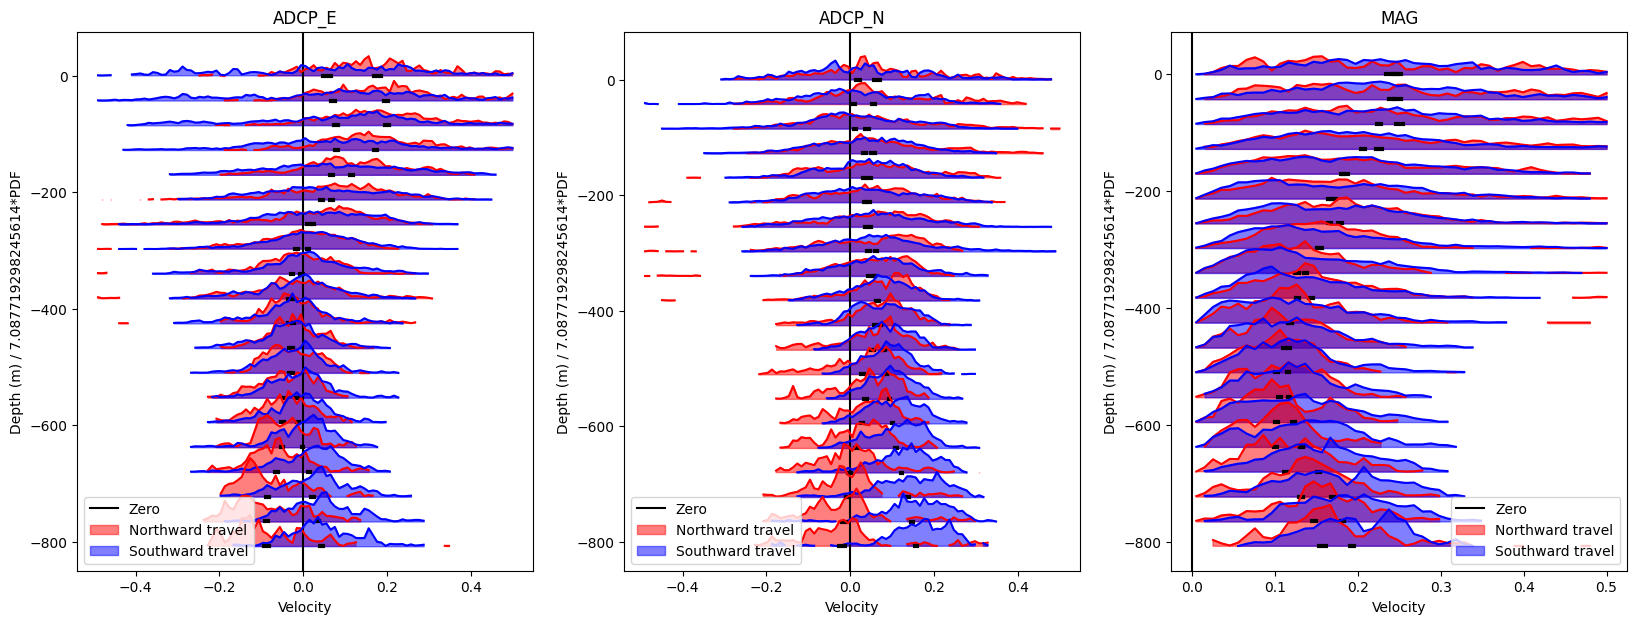

In [26]:
process_adcp.verify_depth_bias(out, yaxis, options)

### 2.7 Correct shear bias

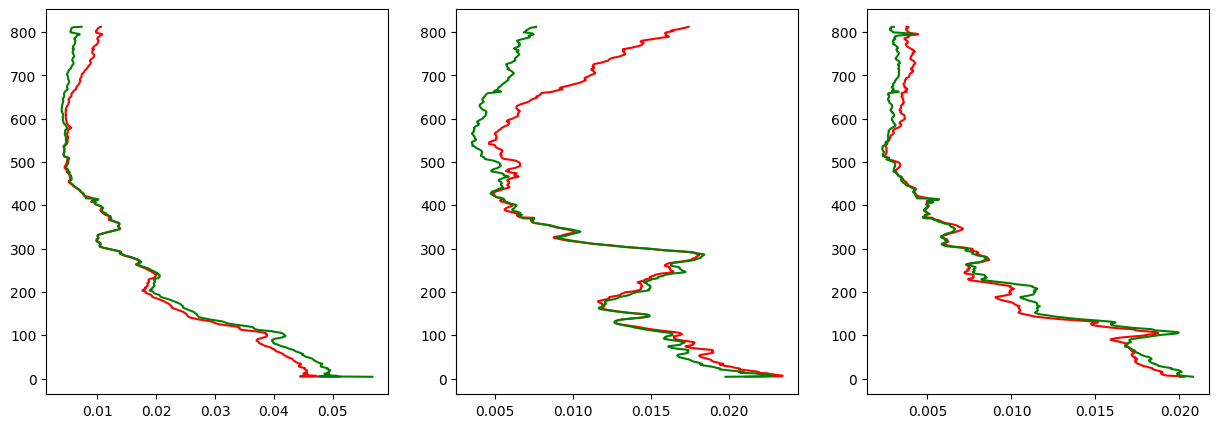

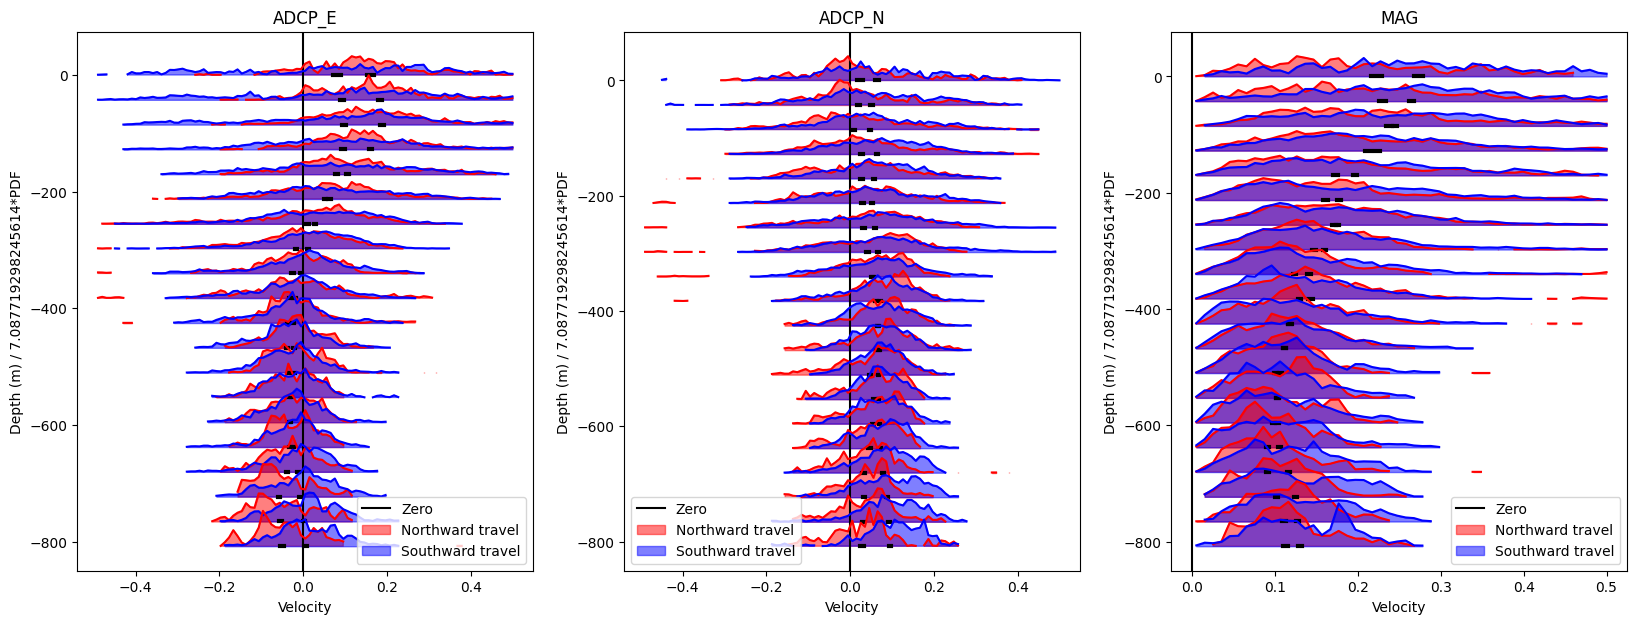

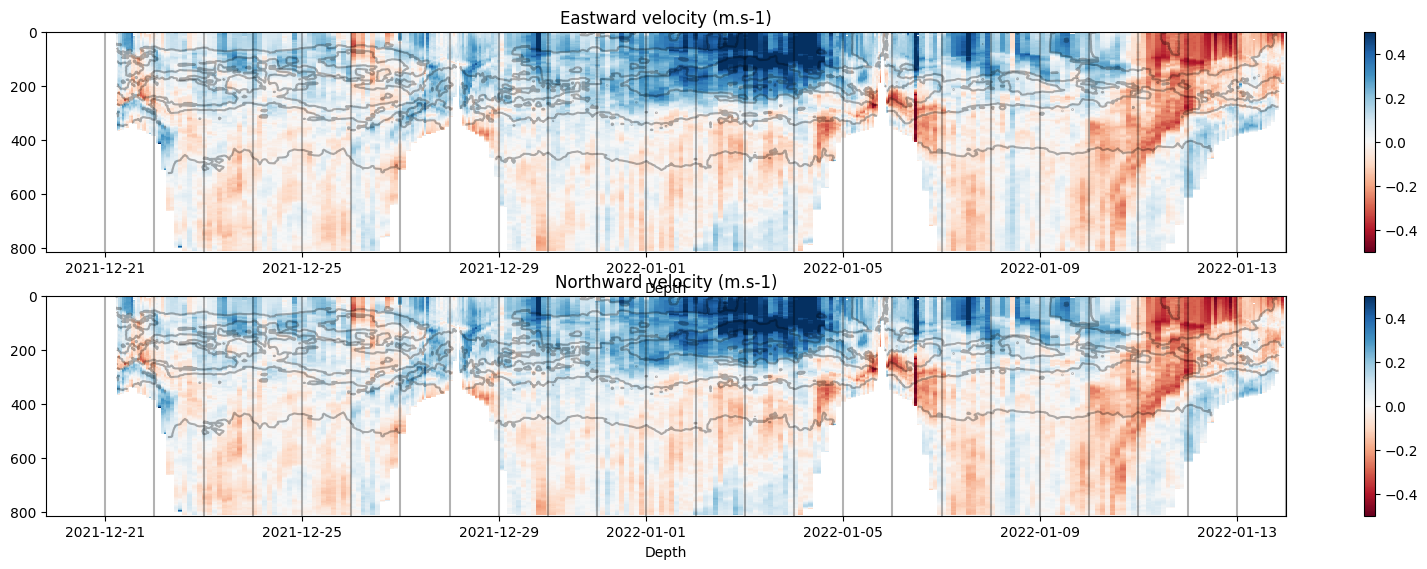

In [27]:
out = process_adcp.calc_bias(out, yaxis, taxis, days, options)

## 2.8 Create xarray DataSet from `out`

In [28]:
ds = process_adcp.make_dataset(out)
ds.to_netcdf("gridded_velocity.nc")

<xarray.Dataset>
Dimensions:           (depth_bin: 814, profile_num: 322)
Coordinates:
  * profile_num       (profile_num) int64 0 1 2 3 4 5 ... 317 318 319 320 321
  * depth_bin         (depth_bin) int64 0 1 2 3 4 5 ... 808 809 810 811 812 813
Data variables: (12/25)
    ADCP_E            (depth_bin, profile_num) float64 nan nan nan ... nan nan
    ADCP_N            (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Sh_E              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Sh_N              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Sh_U              (depth_bin, profile_num) float64 nan nan nan ... nan nan
    Heading           (depth_bin, profile_num) float64 nan nan nan ... nan nan
    ...                ...
    dive_number       (depth_bin, profile_num) float64 nan nan nan ... nan nan
    speed_e           (depth_bin, profile_num) float64 nan nan nan ... nan nan
    speed_n           (depth_bin, profile_num) float64 nan nan nan ... nan nan
    DAC_E             (depth_bin, profile_num) float64 nan nan nan ... nan nan
    DAC_N             (depth_bin, profile_num) float64 nan nan nan ... nan nan
    profile_datetime  (profile_num) datetime64[ns] 2021-12-21T05:17:32.286280...